# Plan de Trabajo:

¿Cuál sería tu enfoque y plan de trabajo para abordar este desafío? ¿Qué **tareas consideras 
esenciales** para la ejecución de este proyecto? ¿Qué elementos específicos desarrollarías para 
resolver el problema planteado? Incluye una **estimación del tiempo** que dedicarías a cada fase y 
explique cómo tu solución impactaría positivamente en la situación actual de la empresa.

Primero abordando tareas escenciales y tiempo.

+ Análisis Inicial, revisando que la data enviada tenga sentido y entenderla.
+ Revisar capacidad de predicción del modelo anterior, suponiendo que el modelo **predice una vez al final de cada año.** La idea es mejorar el MAE del modelo antiguo con uno nuevo. (y con ello ahorrar costos)
+ Limpiar data y revisar/corregir formato de esta (missing values y datos de fecha que tengan formato fecha)
+ Crear nuevas variables relevantes para el problema 
**(4 horas hasta este checkpoint)**
+ Crear data de entrenamiento y validación.
+ Crear modelo o pipeline dependiendo si tiene missing values.(30 min este punto con el anterior).
+ El paso anterior incluye escoger el modelo y pivotear distintas soluciones comparando con el mae del modelo antiguo como referencia. Investigar nuevos modelos en caso no se logre bajar el MAE al primer intento. 
 **(6 horas hasta este checkpoint)**
+ Crear en base a los primeros puntos la data del X_test, vale decir para el 2024.
+ Aplicar función de modelo ya construída a la data del punto anterior.
 **(7 horas hasta este checkpoint)**

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression 
# from scipy.signal import periodogram
import seaborn as sns
from datetime import datetime


from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Análisis Exploratorio

In [2]:
data_dir ="store_series"
dtype = {
    'prod_id': 'category',
    'precio_promedio': 'float32',
    'ventas': 'float32',
    'modelo_actual': 'float32',
}
sales = pd.read_csv(
    'desafio_modelo_de_demanda.csv',
    dtype=dtype,
    parse_dates=['fecha'],
)
sales = sales.sort_values(by=['fecha','prod_id']).reset_index(drop=True)

In [3]:
sales.head(2)

,fecha,prod_id,precio_promedio,ventas,modelo_actual
0,2012-01-01,101,2993.408447,1600.0,1692.687012
1,2012-01-01,102,7917.199707,1032.0,1071.957275


In [4]:
sales.tail(2)

,fecha,prod_id,precio_promedio,ventas,modelo_actual
80746,2023-12-01,997,6801.271973,2272.0,1778.950439
80747,2023-12-01,998,9080.789062,1906.0,1030.493530


In [5]:
sales.dtypes

fecha              datetime64[ns]
prod_id                  category
precio_promedio           float32
ventas                    float32
modelo_actual             float32
dtype: object

In [6]:
sales.shape

(80748, 5)

In [7]:
sales.drop_duplicates(subset=['fecha','prod_id'],inplace=True)
sales.shape

(80748, 5)

No hay duplicados! eso es muy bueno, ya que si hubiera duplicados con misma fecha y id producto no sabríamos a cual de los registros creerle (en caso fueran distintos en otras columnas)!

In [8]:
meses_totales= len(sales.fecha.unique())
todos_productos = len(sales.prod_id.unique())
print(f"meses medidos: {meses_totales}")
print(f"productos diferentes: {todos_productos}")

meses medidos: 144
productos diferentes: 1000


Notemos que si existieren productos relativamente nuevos aparecerían después de cierto registro en adelante. Lo que es normal, sin embargo es importante ver si hay vacios. Es decir, periodos que ciertos productos no aparezcan. Esa es la idea de la variable de abajo, ver cuantos registros podrían estar faltando.

In [9]:
periodos_sin_muestra_productos = 100*(meses_totales*todos_productos - sales.shape[0])/(meses_totales*todos_productos)
print(f"tenemos un {round(periodos_sin_muestra_productos,3)}% de todos los productos durante el periodo de {round(meses_totales/12,2)} años")

tenemos un 43.925% de todos los productos durante el periodo de 12.0 años


Probablemente esto sea porque hay **productos que se dejaron de comprar en algún periodo** y otros que son **nuevos** y se **comenzaron a comprar despues** de cierto periodo. Lo preocupante serían los productos que tienen intermitencia, es decir que se compran unos periodos y otros no. Esto es lo que se quiere ver con los siguientes bloques de código.

## Análisis Comportamiento productos

In [10]:
def productos_nuevos_antiguos(sales):
    # buscamos la primera vez que se pide un producto
    new_sales = sales.copy()
    new_sales = new_sales.drop_duplicates(subset=['prod_id'], keep='first')
    #identificando productos antiguos como todos los que no sean nuevos.
    sales['tipo_de_producto'] = 'antiguo'
    sales.loc[new_sales.index,'tipo_de_producto'] = 'nuevo'
    #poniendo la fecha productos nuevos
    sales_copy = sales.merge(new_sales[['prod_id','fecha','ventas']] , on='prod_id', how='left')
    sales_copy.rename(columns={"fecha_y": "fecha_producto_nuevo",
                               "fecha_x": "fecha",
                               "ventas_y": "ventas_nuevo",
                               "ventas_x": "ventas"}, inplace=True)
    sales = sales_copy.copy()
    return sales
   

In [11]:
def agregar_fechas_estacionalidad(sales):
    # mes que el producto salio (ajustar por estacionalidad en caso que exista en modelos)
    sales['mes_producto_nuevo'] = sales['fecha_producto_nuevo'].dt.month
    sales['mes_actual'] = sales['fecha'].dt.month
    import calendar
    sales['mes_producto_nuevo'] = sales['mes_producto_nuevo'].apply(lambda x: calendar.month_abbr[x])
    sales['mes_actual'] = sales['mes_actual'].apply(lambda x: calendar.month_abbr[x])
    # números de meses desde que el producto salio
    sales['meses_vendiendo_producto'] = sales.fecha.dt.to_period('M') - sales.fecha_producto_nuevo.dt.to_period('M')
    sales['meses_vendiendo_producto'] = sales['meses_vendiendo_producto'].apply(lambda x: x.n)
    sales['año_producto_nuevo'] = sales['fecha_producto_nuevo'].apply(lambda x: int(str(x)[:4]))
    sales['año_actual'] = sales['fecha'].apply(lambda x: int(str(x)[:4]))
    sales['años_desde_salida_prod'] = sales['año_actual'] - sales['año_producto_nuevo']
    return sales

In [12]:
sales = productos_nuevos_antiguos(sales)

In [13]:
sales = agregar_fechas_estacionalidad(sales)

In [14]:
# tomemos una fecha cualquiera en este caso '2014-01-01' y busquemos un producto nuevo 
sales[(sales['fecha']=='2014-01-01') & (sales['tipo_de_producto']=='nuevo')]

,fecha,prod_id,precio_promedio,ventas,modelo_actual,tipo_de_producto,fecha_producto_nuevo,ventas_nuevo,mes_producto_nuevo,mes_actual,meses_vendiendo_producto,año_producto_nuevo,año_actual,años_desde_salida_prod
4360,2014-01-01,148,7348.688477,978.0,981.188782,nuevo,2014-01-01,978.0,Jan,Jan,0,2014,2014,0
4364,2014-01-01,160,7774.584473,1820.0,1913.088379,nuevo,2014-01-01,1820.0,Jan,Jan,0,2014,2014,0
4366,2014-01-01,165,1347.390991,1259.0,1321.586548,nuevo,2014-01-01,1259.0,Jan,Jan,0,2014,2014,0
4375,2014-01-01,181,5273.046875,1827.0,1876.317383,nuevo,2014-01-01,1827.0,Jan,Jan,0,2014,2014,0
4376,2014-01-01,187,7827.888184,1321.0,1208.539185,nuevo,2014-01-01,1321.0,Jan,Jan,0,2014,2014,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4665,2014-01-01,965,1875.467896,884.0,824.825500,nuevo,2014-01-01,884.0,Jan,Jan,0,2014,2014,0
4670,2014-01-01,98,4493.819336,1840.0,1680.616699,nuevo,2014-01-01,1840.0,Jan,Jan,0,2014,2014,0
4671,2014-01-01,980,3613.050781,2360.0,2383.211670,nuevo,2014-01-01,2360.0,Jan,Jan,0,2014,2014,0
4672,2014-01-01,984,1728.785156,2891.0,3062.295166,nuevo,2014-01-01,2891.0,Jan,Jan,0,2014,2014,0


In [15]:
sales[sales['prod_id']=='148']

,fecha,prod_id,precio_promedio,ventas,modelo_actual,tipo_de_producto,fecha_producto_nuevo,ventas_nuevo,mes_producto_nuevo,mes_actual,meses_vendiendo_producto,año_producto_nuevo,año_actual,años_desde_salida_prod
4360,2014-01-01,148,7348.688477,978.0,981.188782,nuevo,2014-01-01,978.0,Jan,Jan,0,2014,2014,0
4694,2014-02-01,148,6635.274414,1365.0,1206.565308,antiguo,2014-01-01,978.0,Jan,Feb,1,2014,2014,0
5028,2014-03-01,148,6752.338379,1010.0,1137.063843,antiguo,2014-01-01,978.0,Jan,Mar,2,2014,2014,0
5362,2014-04-01,148,4796.666992,803.0,973.082397,antiguo,2014-01-01,978.0,Jan,Apr,3,2014,2014,0
5696,2014-05-01,148,7131.911133,700.0,959.651672,antiguo,2014-01-01,978.0,Jan,May,4,2014,2014,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77608,2023-08-01,148,8212.596680,1287.0,1307.490845,antiguo,2014-01-01,978.0,Jan,Aug,115,2014,2023,9
78243,2023-09-01,148,3914.583008,1749.0,1460.439331,antiguo,2014-01-01,978.0,Jan,Sep,116,2014,2023,9
78878,2023-10-01,148,8185.054199,758.0,1241.788818,antiguo,2014-01-01,978.0,Jan,Oct,117,2014,2023,9
79513,2023-11-01,148,7776.466309,1393.0,1402.204102,antiguo,2014-01-01,978.0,Jan,Nov,118,2014,2023,9


In [16]:
sales.mes_producto_nuevo.unique()

array(['Jan'], dtype=object)

**Notemos que todos los productos nuevos son en enero!**

In [17]:
def productos_ultimo_pedido(sales):
    # buscamos ultima vez que se ha pedido un producto
    # esto es importante ya que vamos a predecir la demanda de los productos que se siguen vendiendo
    new_sales = sales.copy()
    new_sales = new_sales.drop_duplicates(subset=['prod_id'], keep='last')
    sales['ultimo_pedido'] = 0
    sales.loc[new_sales.index,'ultimo_pedido'] = 1
    return sales

In [18]:
sales = productos_ultimo_pedido(sales)

In [19]:
# si tomamos una fecha digamos que tomamos de nuevo 2014-01-01 
# todos los productos con esta fecha no se han vuelto a pedir por lo que es
# poco probable se pidan de nuevo (tendría que existir alguna orden especial)
sales[(sales['fecha']<='2014-01-01') & (sales['ultimo_pedido']==1)]

,fecha,prod_id,precio_promedio,ventas,modelo_actual,tipo_de_producto,fecha_producto_nuevo,ventas_nuevo,mes_producto_nuevo,mes_actual,meses_vendiendo_producto,año_producto_nuevo,año_actual,años_desde_salida_prod,ultimo_pedido
1287,2012-12-01,257,9113.821289,1460.0,1188.407104,antiguo,2012-01-01,1790.0,Jan,Dec,11,2012,2012,0,1
1311,2012-12-01,446,5137.767090,1352.0,512.350647,antiguo,2012-01-01,2414.0,Jan,Dec,11,2012,2012,0,1
1329,2012-12-01,575,4814.721680,1475.0,1011.335754,antiguo,2012-01-01,1456.0,Jan,Dec,11,2012,2012,0,1
1333,2012-12-01,652,1472.720093,883.0,1227.323975,antiguo,2012-01-01,1186.0,Jan,Dec,11,2012,2012,0,1
1362,2012-12-01,868,3502.604980,1832.0,870.053589,antiguo,2012-01-01,1390.0,Jan,Dec,11,2012,2012,0,1
1372,2012-12-01,959,4228.723633,582.0,1512.232910,antiguo,2012-01-01,2164.0,Jan,Dec,11,2012,2012,0,1
4140,2013-12-01,232,10169.667969,1134.0,772.192566,antiguo,2013-01-01,2140.0,Jan,Dec,11,2013,2013,0,1
4142,2013-12-01,237,6748.857422,2152.0,1294.381836,antiguo,2012-01-01,2625.0,Jan,Dec,23,2012,2013,1,1
4148,2013-12-01,275,4259.012695,1530.0,917.133911,antiguo,2012-01-01,1433.0,Jan,Dec,23,2012,2013,1,1
4164,2013-12-01,331,2693.588135,2006.0,1575.343262,antiguo,2012-01-01,819.0,Jan,Dec,23,2012,2013,1,1


In [20]:
# revisando el primer producto de id:257 debieran llegar hasta el periodo 2012-12-01 como muestra arriba
sales[sales['prod_id']=='257'] 

,fecha,prod_id,precio_promedio,ventas,modelo_actual,tipo_de_producto,fecha_producto_nuevo,ventas_nuevo,mes_producto_nuevo,mes_actual,meses_vendiendo_producto,año_producto_nuevo,año_actual,años_desde_salida_prod,ultimo_pedido
22,2012-01-01,257,4635.903809,1790.0,1714.768799,nuevo,2012-01-01,1790.0,Jan,Jan,0,2012,2012,0,0
137,2012-02-01,257,5693.988281,1738.0,1885.466675,antiguo,2012-01-01,1790.0,Jan,Feb,1,2012,2012,0,0
252,2012-03-01,257,6579.878906,1287.0,1554.949585,antiguo,2012-01-01,1790.0,Jan,Mar,2,2012,2012,0,0
367,2012-04-01,257,6587.557617,212.0,1323.537231,antiguo,2012-01-01,1790.0,Jan,Apr,3,2012,2012,0,0
482,2012-05-01,257,6191.021973,547.0,1028.156982,antiguo,2012-01-01,1790.0,Jan,May,4,2012,2012,0,0
597,2012-06-01,257,7487.540039,1810.0,914.202393,antiguo,2012-01-01,1790.0,Jan,Jun,5,2012,2012,0,0
712,2012-07-01,257,8105.531738,49.0,660.124390,antiguo,2012-01-01,1790.0,Jan,Jul,6,2012,2012,0,0
827,2012-08-01,257,9946.311523,322.0,725.440979,antiguo,2012-01-01,1790.0,Jan,Aug,7,2012,2012,0,0
942,2012-09-01,257,7390.905273,996.0,765.214172,antiguo,2012-01-01,1790.0,Jan,Sep,8,2012,2012,0,0
1057,2012-10-01,257,9751.706055,604.0,460.740967,antiguo,2012-01-01,1790.0,Jan,Oct,9,2012,2012,0,0


In [21]:
sales[sales['ultimo_pedido']==1]['mes_actual'].unique()

array(['Dec'], dtype=object)

**Todos los últimos pedidos son en diciembre.**

Hay un tema curioso en esta tabla el producto 257 es nuevo y tiene una venta mayor que lo que pronostico el modelo_actual, ¿Cómo se pudo vender más de lo que dice el modelo? ¿Estarán comprando más de lo que indica el modelo? O bien ¿Estarán usando inventario, y el producto más que ser nuevo es un cambio de ID por sistema? Se dejará esa duda en el aire, ya que por ahora nos centraremos en el comportamiento de demanda de productos en base a que productos piden y no a cuanto. 	

Notamos que hay productos que son "nuevos" o por lo menos su id es. Y por otro lado hay productos que no se han vuelto a pedir. La idea de este análisis previo es entender la demanda de productos a un nivel de variedad de productos que piden. Falta todavía un análisis de pedido global, es decir, cuando se gasta mensualmente en producto y ver si ese valor macro oscila mucho o no.

Dicho de otra forma este problema se dividirá en tres partes
+ Revisar que productos se pedirán efectivamente el próximo mes (análisis producto)
+ Revisar montos globales a pedir (análisis macro)
+ Revisar cantidad a pedir para cada producto (análisis producto)

**Una pregunta interesante a nivel de productos es, existirán productos que normalmente se compran pero existen periodos en donde no se compran (no apareren estas id en ciertos periodos)?**

In [22]:
# para ver si se existen periodos sin comprar es necesario ordenar por id_productos y ver "saltos"
# en donde no hubo compras
def productos_faltantes_peridos(sales):
    sales = sales.sort_values(by=['prod_id','fecha'])
    sales['fecha_anterior'] = sales['fecha'].shift(1)
    sales['producto_anterior'] = sales['prod_id'].shift(1)
    sales['productos_iguales'] =  np.where(sales['producto_anterior']==sales['prod_id'], 1, 0)
    sales.loc[sales['productos_iguales']==1 ,'salto_periodos_meses'] = np.round((sales['fecha'] - sales['fecha_anterior']) / np.timedelta64(1, 'M'))
    # no necesitamos todas esta columna acá limpiamos
    sales.drop(['fecha_anterior', 'producto_anterior','productos_iguales'], axis=1,inplace=True)
    return sales

In [23]:
sales = productos_faltantes_peridos(sales)

In [24]:
sales.salto_periodos_meses.unique()

array([nan,  1.])

**Aprendimos algo muy importante. Una vez que un productos no se compra un periodo, tampoco se comprará el siguiente. Por lo tanto para calcular que productos estarán de un periodo para otro se considerarán solo, productos que estuvieron el periodo anterior.**

**Esto implica que el modelo, debería recibir modificaciones adicionales en Enero, ya que salen productos del mercado y entran otros nuevos.**

In [25]:
sales.drop(["salto_periodos_meses"],axis=1,inplace=True)

## Complejidades Encontradas hasta ahora

+ El hecho de que hayan productos nuevos en distintos periodos, complica el usar lag. Por ejemplo, si quisiéramos usar lag 12 como variable para predecir venta de un producto, probablemente esta variable sea nula. Por lo que parece mejor usar **one-hot-encoding con los meses**.

+ Hay variables como el precio promedio, que probablemente son **difíciles de tener en producción** antes de la fecha que se calculan las ventas.

+ Otro tema con los **productos nuevos** es predecir su **venta inicial**, ya que no tenemos categorías u otra variable para identificarlos. Incluso con los datos del cvs ni siquiera podríamos predecir si el próximo mes llegará un nuevo producto o se dejará de vender otro. (o nueva id.)

## Análisis Comportamiento Compra 
**(Esto es para entender un poco más el problema, pero la parte Importante está abajo de esto, en la sección de Modelo)**

In [26]:
sales['valor_ventas'] = sales['ventas']*sales['precio_promedio']

In [27]:
df_gasto_mensual = sales[['fecha','valor_ventas']].groupby(['fecha']).sum().reset_index()
df_gasto_mensual

,fecha,valor_ventas
0,2012-01-01,8.480810e+08
1,2012-02-01,7.814572e+08
2,2012-03-01,4.172850e+08
3,2012-04-01,4.263876e+08
4,2012-05-01,4.072787e+08
...,...,...
139,2023-08-01,3.137107e+09
140,2023-09-01,3.261130e+09
141,2023-10-01,3.241465e+09
142,2023-11-01,3.159485e+09


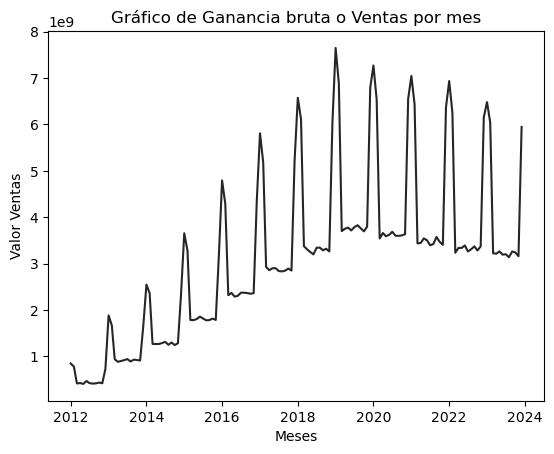

In [28]:
fig, ax = plt.subplots()
ax.plot(df_gasto_mensual['fecha'], df_gasto_mensual['valor_ventas'], '-', color='0.15')
ax.set_ylabel('Valor Ventas')
ax.set_xlabel('Meses')
ax.set_title('Gráfico de Ganancia bruta o Ventas por mes');

Se observa claramente que depende de la temporada (el gráfico tiene estacionalidad) cuanto se va a vender y comprar. A demás una tendencia positiva desde el 2012 hasta el 2019. Luego hay una tendencia negativa, podríamos modelar esto con un **término cúbico**para darle más flexibilidad al modelo.

In [29]:
df_gasto_mensual['venta_año_anterior'] = df_gasto_mensual['valor_ventas'].shift(12)
df_gasto_mensual['venta_mes_anterior'] = df_gasto_mensual['valor_ventas'].shift(1)
df_gasto_mensual['variacion_porcentual_año'] = (df_gasto_mensual['valor_ventas']-df_gasto_mensual['venta_año_anterior'])/(df_gasto_mensual['venta_año_anterior'])
df_gasto_mensual = df_gasto_mensual[df_gasto_mensual['fecha']>="2013-01-01"]

df_gasto_mensual[df_gasto_mensual['fecha']>="2023-01-01"]


,fecha,valor_ventas,venta_año_anterior,venta_mes_anterior,variacion_porcentual_año
132,2023-01-01,6.480549e+09,6.934311e+09,6.154899e+09,-0.065437
133,2023-02-01,6.042789e+09,6.257660e+09,6.480549e+09,-0.034337
134,2023-03-01,3.222212e+09,3.234012e+09,6.042789e+09,-0.003649
135,2023-04-01,3.214045e+09,3.338550e+09,3.222212e+09,-0.037293
136,2023-05-01,3.262916e+09,3.337707e+09,3.214045e+09,-0.022408
137,2023-06-01,3.192974e+09,3.391503e+09,3.262916e+09,-0.058537
138,2023-07-01,3.202990e+09,3.261697e+09,3.192974e+09,-0.017999
139,2023-08-01,3.137107e+09,3.309612e+09,3.202990e+09,-0.052122
140,2023-09-01,3.261130e+09,3.371336e+09,3.137107e+09,-0.032689
141,2023-10-01,3.241465e+09,3.282407e+09,3.261130e+09,-0.012473


La venta de otros periodos tienen mucha más oscilación, puede ser por diversos motivos, tomamos el último periodo acá para ver que tan estable es considerar la venta del año pasado para prónosticar las nuevas ventas. Al parecer están muy correlacionadas.

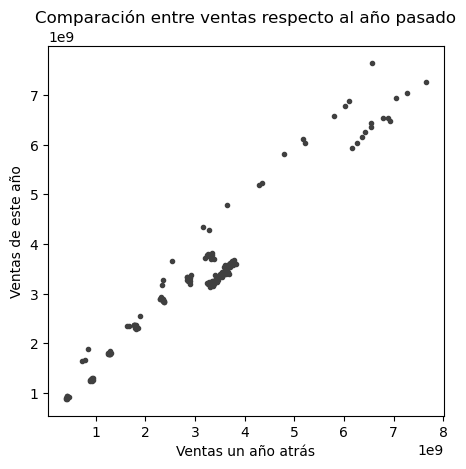

In [30]:
fig, ax = plt.subplots()
ax.plot(df_gasto_mensual['venta_año_anterior'], df_gasto_mensual['valor_ventas'], '.', color='0.25')
ax.set_aspect('equal')
ax.set_ylabel('Ventas de este año')
ax.set_xlabel('Ventas un año atrás')
ax.set_title('Comparación entre ventas respecto al año pasado');

Se ve casi una linea recta, es decir, hay una gran correlación entre las ventas de ahora con respecto al año pasado.

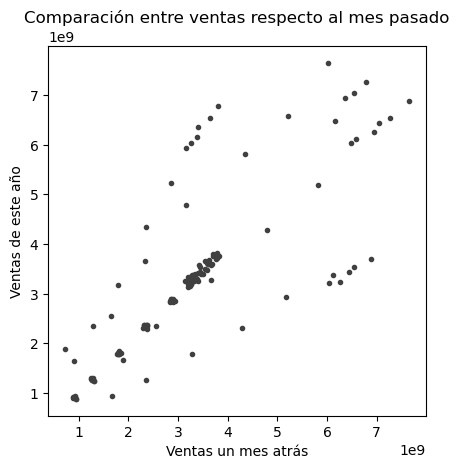

In [31]:
fig, ax = plt.subplots()
ax.plot(df_gasto_mensual['venta_mes_anterior'], df_gasto_mensual['valor_ventas'], '.', color='0.25')
ax.set_aspect('equal')
ax.set_ylabel('Ventas de este año')
ax.set_xlabel('Ventas un mes atrás')
ax.set_title('Comparación entre ventas respecto al mes pasado');

La correlación es bastante más baja respecto a la comparación al mes pasado

Nota si la venta fuera diaria en lugar de mensual se pueden hacer "periodogram" para identificar más estacionalidades. (En mi Github personal tengo cómo hacer esto.)

Un punto importante es usar en el modelo los **mismos datos que se tendrían en producción**. Por ejemplo, se podría usar la **variación porcentual del precio** para estimar el nivel de ventas (esto serviría ya que sería algo así como medir **elasticidad** de demanda vs precio) pero si el precio promedio **no se tiene antes del mes** que queremos predecir esa variable **no la podemos incorporar en el modelo**.

Lo que si podríamos usar es el precio del mes actual, por ejemplo, enero para y del enero del año pasado para predecir la demanda del mes de Febrero.

# Modelos 
Este modelo híbrido, está construído de la siguiente forma:

+ Creación de tendencia y estacionalidad por el mes y año actual con regresión lineal
+ Caracterización del producto en base al año que se lanzo y su venta inicial. 


In [32]:
# revisar nulos
# sales.isnull().values.any() # ->False estamos ok con esto
# trend no mejoraron el modelo así que se sacaron.
# sales['año_trend_lineal'] = sales['fecha'].apply(lambda x: int(str(x)[:4]) - 2012)
# sales['año_trend_cuadratico'] = sales['año_trend_lineal'].apply(lambda x: (x)**2)
# sales['año_trend_cubico'] = sales['año_trend_lineal'].apply(lambda x: (x)**3)

index_train = sales[(sales['fecha']>="2013-01-01") & (sales['fecha']<"2023-01-01")].index
index_val = sales[(sales['fecha']>="2023-01-01")].index

def modelo(sales,index_train,index_val):
    ## Identificación de Features
    features_linear = ['mes_actual', 'año_actual']

    features_ensembler = ['ventas_nuevo','año_producto_nuevo']
    features = features_linear + features_ensembler

    col_to_predict = 'ventas'
    
    X = sales[features]
    y = sales[col_to_predict]
    X = pd.get_dummies(X,dummy_na=False) # dummy_na=False no es necesario no hay nulos.
    X.drop(['mes_actual_Jan'],axis=1, inplace=True)
    
    # Creando data de entrenamiento y validación 
    X_train =  X.loc[index_train] 
    y_train = y.loc[index_train] 
    X_val =  X.loc[index_val] 
    y_val = y.loc[index_val] 
    
    # calculemos mae del modelo actual
    # sales_val = sales.loc[index_val]
    # sales_val['mae'] = abs(sales_val['ventas']-sales_val['modelo_actual'])
    # mae es: 441.97076
    # mae_modelo_viejo = sales_val['mae'].mean()
    
    ###
    # REGRESIÓN LINEAL
    ###
    features_linear_new_col = [col for col in list(X.columns) if col not in features_ensembler]
    reg = LinearRegression().fit(X_train[features_linear_new_col] ,y_train)
    predictions_1_train_data = reg.predict(X_train[features_linear_new_col])    
    predictions_1_val_data = reg.predict(X_val[features_linear_new_col])
    ###
    # Ojo el mae tiene solo sentido si y solo es data de validación, para la de testeo no existe el Y_val
    ###
    try:
        mae_base = mean_absolute_error(y_val, predictions_1_val_data)
    except:
        pass
    
    ###
    # ENSEMBLE LEARNING METHOD
    ###
    # mejor hiperparametro fue 60 de los testeados
    estimator  = 60 
    model = RandomForestRegressor(n_estimators=estimator ,random_state=0,n_jobs=-1)
    model.fit(X_train[features_ensembler] ,y_train-predictions_1_train_data)
    
    # Aca abajo comienza la validación, notese que usamos solo predict en reg y en model usando X_val
    y_pred = reg.predict(X_val[features_linear_new_col])
    predicciones = y_pred + model.predict(X_val[features_ensembler])
    mae = 0
    ###
    # Ojo el mae tiene solo sentido si y solo es data de validación, para la de testeo no existe el Y_val
    ###
    try:
        mae = mean_absolute_error(y_val, predicciones)
    except:
        pass
    return mae,predicciones

In [33]:
mae, predicciones = modelo(sales,index_train,index_val)
print(mae)

437.1761979560619


# Ventajas de un modelo a otro

In [34]:
# calculemos mae del modelo actual
sales_val = sales.loc[index_val]
sales_val['mae'] = abs(sales_val['ventas']-sales_val['modelo_actual'])
mae_modelo_viejo = sales_val['mae'].mean() 
print(f"mae antiguo {mae_modelo_viejo}")
print(f"mae nuevo {mae}")
mejora_en_mae = mae_modelo_viejo - mae
print(f"mejora entre un mae y otro es de: {round(mejora_en_mae,2)}")

mae antiguo 441.97076416015625
mae nuevo 437.1761979560619
mejora entre un mae y otro es de: 4.79


In [35]:
sales_val = sales.loc[index_val]
sales_val['nuevas_predicciones'] = predicciones

In [36]:
# se asumirá que el sobre inventario tiene el mismo costo que la falta de inventario
# Esto en la gran mayoria de casos no es cierto, pero es para validar rapidamente mejora económica
sales_val['diferencia_modelo_nuevo'] = abs(sales_val['nuevas_predicciones']-sales_val['ventas'])
sales_val['diferencia_modelo_antiguo'] = abs(sales_val['modelo_actual']-sales_val['ventas'])

# Ventajas económicas #precio_promedio
sales_val['perdida_nuevo_modelo'] = sales_val['diferencia_modelo_nuevo']*sales_val['precio_promedio'] 
sales_val['perdida_antiguo_modelo'] = sales_val['diferencia_modelo_antiguo']*sales_val['precio_promedio'] 

sales_val['ganancia_modelo_nuevo'] = sales_val['perdida_antiguo_modelo']-sales_val['perdida_nuevo_modelo']
sales_val['ganancia_modelo_nuevo'].mean()

69311.48573469609

In [37]:
sales_val['precio_promedio'].mean()

5420.9595

In [38]:
#sales_val[['ventas','precio_promedio','modelo_actual','nuevas_predicciones','diferencia_modelo_antiguo','diferencia_modelo_nuevo','ganancia_modelo_nuevo']]

In [39]:
# ganancia_total por cambiarse al nuevo modelo!
ganancia_total = sales_val['ganancia_modelo_nuevo'].sum()
ganancia_total

528153521.2983842

In [40]:
ventas_totales = sales_val['valor_ventas'].sum()

In [41]:
(ganancia_total/ventas_totales)*100

1.1151203557085896

In [42]:
# Algunas Verificaciones con respecto al mae
#sales_val['diferencia_modelo_nuevo'].mean() #corroborar que de lo mismo que dio arriba, y todo ok!
#sales_val['diferencia_modelo_antiguo'].mean() #corroborar que de lo mismo que dio arriba, y todo ok!

# Conclusión

Logramos mejorar el MAE del modelo actual, prediciendo un año completo con una mejora de mae de 4.8. Es decir, el error que tiene el modelo en predicir de más o de menos es de aproximadamente 5 productos. Esto es para cada producto, para cada mes.

Si se hubierá usado el modelo propuesto aquí solo el año 2023 se hubiera ahorrado **$528.153.521** 


# Construcción

Recordemos que todos los productos nuevos parten en enero y los productos que se van/reemplazan tienen su última venta en diciembre.
Desgraciadamente no tenemos como saber cuales son los productos nuevos que llegarán, por lo que **las ventas de los productos del 2023 se extrapolarán al 2024**

La forma más eficiente de crear un Dataframe es por medio de listas! eso se hará en los siguientes bloques de código.

### variable que necesitamos incluir para correr el modelo son:
+ fecha -> año y mes (actual)
+ prod_id -> venta_año_producto_nuevo, año_producto_nuevo (recordemos que el mes siempre es enero o sino se incluiría el mes)

In [43]:
list_product_2023 = list(sales[(sales['fecha']=="2023-12-01")].prod_id.unique())
list_product_2023[:5]

['0', '1', '101', '103', '105']

In [44]:
date_list_temp = [str(f"2024-{x}-01") for x in range(10,13)]
date_list = [str(f"2024-0{x}-01") for x in range(1,10)] + date_list_temp


In [45]:
# testing descomentar para entender lo que se hace abajo
a = ['primer_elem','segundo_elem','tercer_elem']
#print(f"a * 2:  {a * 2}")
a2 = []
for elem in a:
    a2.extend([elem]*2)
#a2  

In [46]:
lista_total_fechas = []
for date in date_list:
    lista_total_fechas.extend([date]*len(list_product_2023))
lista_total_productos_2023 = list_product_2023*len(date_list)

In [47]:
assert len(lista_total_productos_2023) == len(lista_total_fechas) 
assert len(lista_total_productos_2023) == sales[(sales['fecha']>="2023-01-01")].shape[0] 

In [48]:
X_test_2024 = pd.DataFrame({'fecha':lista_total_fechas, 'prod_id':lista_total_productos_2023})
X_test_2024['fecha'] = pd.to_datetime(X_test_2024['fecha'])
print(X_test_2024.dtypes)
print(X_test_2024.shape)

fecha      datetime64[ns]
prod_id            object
dtype: object
(7620, 2)


In [49]:
sales_2023 = sales[(sales['fecha']=="2023-12-01")][['prod_id','año_producto_nuevo','ventas_nuevo','fecha_producto_nuevo']]
X_test_2024 = X_test_2024.merge(sales_2023,on='prod_id',how='left')
print(X_test_2024.shape)

(7620, 5)


In [50]:
X_test_2024['ventas']= np.nan

In [51]:
X_test_2024 = agregar_fechas_estacionalidad(X_test_2024)
X_test_2024 = X_test_2024[['fecha','prod_id','año_producto_nuevo','ventas_nuevo','año_actual','mes_actual','ventas']]
X_test_2024.head(2)

,fecha,prod_id,año_producto_nuevo,ventas_nuevo,año_actual,mes_actual,ventas
0,2024-01-01,0,2017,1786.0,2024,Jan,NaN
1,2024-01-01,1,2013,928.0,2024,Jan,NaN


In [52]:
new_sales = sales[['fecha','prod_id','año_producto_nuevo','ventas_nuevo','año_actual','mes_actual','ventas']].copy()
new_sales.head(2)

,fecha,prod_id,año_producto_nuevo,ventas_nuevo,año_actual,mes_actual,ventas
20364,2017-01-01,0,2017,1786.0,2017,Jan,1786.0
21023,2017-02-01,0,2017,1786.0,2017,Feb,2194.0


In [53]:
# perdon la poca orginalidad de nombres
complete_sales = pd.concat([new_sales,X_test_2024], ignore_index=True,sort=False).sort_values(['fecha','prod_id']).reset_index(drop=True)
complete_sales

,fecha,prod_id,año_producto_nuevo,ventas_nuevo,año_actual,mes_actual,ventas
0,2012-01-01,101,2012,1600.0,2012,Jan,1600.0
1,2012-01-01,102,2012,1032.0,2012,Jan,1032.0
2,2012-01-01,106,2012,1541.0,2012,Jan,1541.0
3,2012-01-01,113,2012,1194.0,2012,Jan,1194.0
4,2012-01-01,13,2012,1528.0,2012,Jan,1528.0
...,...,...,...,...,...,...,...
88363,2024-12-01,987,2017,883.0,2024,Dec,NaN
88364,2024-12-01,993,2019,2017.0,2024,Dec,NaN
88365,2024-12-01,996,2019,2939.0,2024,Dec,NaN
88366,2024-12-01,997,2019,1724.0,2024,Dec,NaN


In [54]:
index_train = complete_sales[(complete_sales['fecha']>="2013-01-01") & (complete_sales['fecha']<"2024-01-01")].index
index_test = complete_sales[(complete_sales['fecha']>="2024-01-01")].index

In [55]:
# index_train

In [56]:
# index_test

In [57]:
_,predicciones_2024 = modelo(complete_sales,index_train,index_test)

In [58]:
predicciones_2024

array([2096.37281624, 1822.10396635, 1839.31170241, ..., 2409.4515453 ,
       1921.8308815 , 1618.33533607])

In [59]:
complete_sales_2024 = complete_sales.loc[index_test]
complete_sales_2024['predicciones_ventas'] = predicciones_2024
complete_sales_2024 = complete_sales_2024[['fecha','prod_id','predicciones_ventas']]
complete_sales_2024

,fecha,prod_id,predicciones_ventas
80748,2024-01-01,0,2096.372816
80749,2024-01-01,1,1822.103966
80750,2024-01-01,101,1839.311702
80751,2024-01-01,103,1849.943728
80752,2024-01-01,105,1837.456668
...,...,...,...
88363,2024-12-01,987,2303.543711
88364,2024-12-01,993,1364.671110
88365,2024-12-01,996,2409.451545
88366,2024-12-01,997,1921.830881


In [60]:
complete_sales_2024.to_csv('predicciones 2024.csv',index=False)

# Metodología para la Puesta en Producción:
Diseña una metodología para asegurar que el modelo implementado en un entorno productivo 
genera beneficios para la empresa. Explica los pasos clave que seguirías para monitorear y 
mantener el rendimiento del modelo a lo largo del tiempo.

Varios puntos fueron mencioandos durante el notebook, recapitulando y agregando unas cosas:
+ Primero a final de cada año es importante entender que productos nuevos llegarán en enero y los productos que se sacaran de catalogo para calibrar el modelo acorde (Productos que se sacan demanda 0, productos similares entrantes podría usarse modelo +  opinión experto para ajustarlos el primer mes de enero).
+ El modelo funciona con pocas variables, pero es importante siempre tenerlas en consideración. Ellas son las variables de tendencia y estacionalidad del año y mes actual. Y la otra hace relación con el año de los productos nuevos y su venta inicial.
+ El modelo debería correr automaticamente sin ningún tipo de ajuste desde febrero hasta diciembre, suponiendo que entran productos nuevos solo en enero. (los ajustes al modelo, podrían ser solo para agregar nuevas variables explicativas y mejorar aún más su poder predictivo)
+ La ventana de tiempo dado como está construído el modelo es de un año. Esto es porque no se incluyeron lag ni otras variables que dependan del periodo anterior. Este modelo fue pensado para el entregable con una ventana de un año que proporcionara un mejor mae que el modelo antiguo.


**Muchas gracias por revisar mi código hasta acá, abajo incluí abajo las cosas que intente pero no resultaron.** 

# Funciones que se trataron sin éxito / Aprendizajes

La función de lag que se creo parecia muy interesante debido a la estacionalidad y ciclicidad, sin embargo, dado a que hay productos nuevos en distintos periodos no sé puede contar con el lag ya que deja muchos Null, y tratar de imputar estos valores para tantos registros, sería básicamente inventar muchos datos en el análisis así que prefiero descontinuar este rumbo.

In [ ]:
def agregar_lag_venta_producto(sales,lag=12):
    sales = sales.sort_values(by=['prod_id','fecha'])

    sales['producto_anterior'] = sales['prod_id'].shift(lag)
    sales['producto_ventas_anterior'] = sales['ventas'].shift(lag)
    
    sales['productos_iguales'] =  np.where(sales['producto_anterior']==sales['prod_id'], 1, 0)
    sales.loc[sales['productos_iguales']==1 ,f'venta_{lag}_meses_anterior'] = sales['producto_ventas_anterior']
    # no necesitamos todas esta columna acá limpiamos
    sales.drop(['producto_anterior','producto_ventas_anterior','productos_iguales'], axis=1,inplace=True)
    return sales